Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 2719 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 1776         |
|    iterations           | 2            |
|    time_elapsed         | 2            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0036696035 |
|    clip_fraction        | 0.0107       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.000101     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.24e+07     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00243     |
|    std

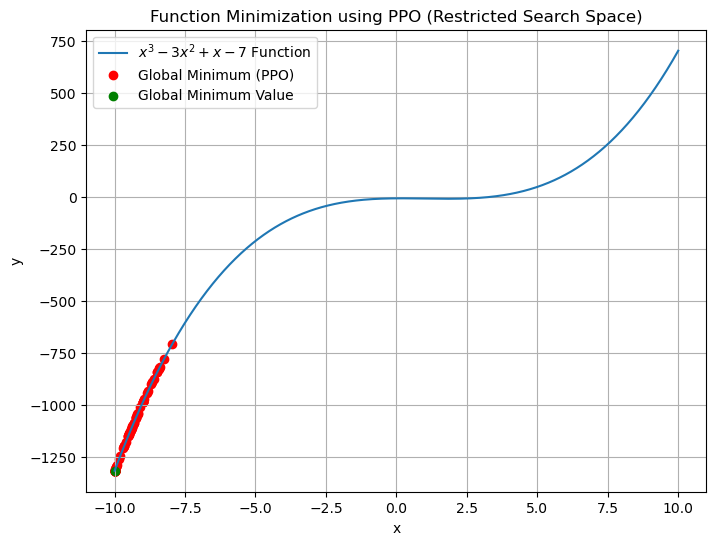

In [5]:
import gym
from stable_baselines3 import PPO
import numpy as np
import matplotlib.pyplot as plt

# Define the custom environment for x^3 - 3x^2 + x - 7 function
class CustomEnv(gym.Env):
    def __init__(self):
        super(CustomEnv, self).__init__()
        self.observation_space = gym.spaces.Box(low=-10, high=10, shape=(1,), dtype=np.float32)
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.state = 0

    def reset(self):
        # Initialize the state within 1 standard deviation radius around -10
        self.state = np.random.normal(loc=-10, scale=1)  
        # Clip the state to stay inside the valid range
        self.state = np.clip(self.state, -10, 10)
        return np.array([self.state])

    def step(self, action):
        # Clip actions to stay inside the valid range
        action = np.clip(action, -1, 1)
        self.state += action[0]
        # Clip the state to stay inside the valid range
        self.state = np.clip(self.state, -10, 10)
        reward = -(self.state**3 - 3*self.state**2 + self.state - 7)  # Objective function (negative because PPO maximizes rewards)
        done = False
        return np.array([self.state]), reward, done, {}

# Create the custom environment
env = CustomEnv()

# Create the PPO agent
model = PPO("MlpPolicy", env, verbose=1)

# Train the agent
model.learn(total_timesteps=10000)

# Evaluate the trained agent
obs = env.reset()
min_values = []
for _ in range(100):
    action, _ = model.predict(obs)
    obs, _, done, _ = env.step(action)
    min_values.append(obs)
    if done:
        obs = env.reset()

# Calculate and print the global minimum value in green
global_min = min(min_values, key=lambda x: x**3 - 3*x**2 + x - 7)
print(f"Global Minimum Value: {global_min}")

# Plot the function and the global minimum
x = np.linspace(-10, 10, 1000)
y = x**3 - 3*x**2 + x - 7

plt.figure(figsize=(8, 6))
plt.plot(x, y, label=r'$x^3 - 3x^2 + x - 7$ Function')
plt.scatter(min_values, [val**3 - 3*val**2 + val - 7 for val in min_values], color='red', label='Global Minimum (PPO)')
plt.scatter(global_min, global_min**3 - 3*global_min**2 + global_min - 7, color='green', label='Global Minimum Value')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Function Minimization using PPO (Restricted Search Space)')
plt.legend()
plt.grid(True)
plt.show()

env.close()
